In [24]:
using LinearAlgebra
using PyPlot
using PyCall
import TensorCrossInterpolation as TCI
using QuanticsTCI
using MSSTA
using SparseIR
using ITensors
ITensors.disable_warn_order()
using JLD2

#include("honeycomb.jl")
#include("kanemele.jl")
#include("latticeplot.jl")
#include("berry.jl")
#include("chern.jl")

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["text.usetex"] = true
#rcParams["text.latex.preamble"] = [r"\usepackage{lmodern}", r"\usepackage{gensymb}", r"\usepackage{amsmath}"]

function displaymatrix(A::Matrix)
    show(stdout, "text/plain", A)
end

function maxlinkdim(n::Integer, localdim::Integer=2)
    return 0:n-2, [min(localdim^i, localdim^(n - i)) for i in 1:(n-1)]
end

maxlinkdim (generic function with 2 methods)

In [3]:
rcParams = PyDict(matplotlib["rcParams"])
rcParams["font.size"] = 18
rcParams["text.usetex"] = true
rcParams["font.family"] = "serif"
rcParams["text.latex.preamble"] = [raw"\usepackage{amsmath}"]
rcParams["font.serif"] = ["Computer Modern Roman"]

1-element Vector{String}:
 "Computer Modern Roman"

# Haldane model

- [See Haldane PRL 1988]

The Bloch Hamiltonian is a 2x2 matrix
$$
H(\mathbf{k}) =
2t_2 \cos\phi \left[ \sum_i \cos(\mathbf{k}\cdot\mathbf{b}_i) \right] \sigma^0 +
t_1 \left[ \sum_i \cos(\mathbf{k} \cdot \mathbf{a_i}) \right] \sigma^1 +
t_1 \left[ \sum_i \sin(\mathbf{k} \cdot \mathbf{a_i}) \right] \sigma^2 +
$$
$$
+\left[m - 2t_2 \sin\phi \sum_i \sin(\mathbf{k}\cdot\mathbf{b_i}) \right] \sigma^3
$$
where $\sigma^\mu$ are Pauli matrices (with identity $\sigma^0$), $a_i$ are distance vectors between nearest neighbours and $b_i$ are between next-nearest neighbours. In the following, I set $t_1 = 1$ as unit of energy, and choose $t_2 = 0.1, \phi = \pi/2$. For this choice of parameters, the model is

 * topologically nontrivial for $|m| < 0.3\sqrt 3$ with Chern number $-1$,
 
 * trivial for $|m| > 0.3\sqrt 3$ (Chern number $0$)
 
 * and has a Dirac point for $|m| = 0.3\sqrt 3$ (Chern number $-1/2$).

Close to the transition, the gap at the dirac point is approximately $2\delta m$, where $\delta m = |m - 0.3\sqrt 3|$. Accordingly, we need a lattice with resolution $\sim \delta m$ to resolve the gap and get the correct Chern number.

In [4]:
pauli0 = [1. 0.; 0. 1.]
pauli = [
    [0. 1.; 1. 0.],
    [0. -1.0im; 1.0im 0.],
    [1. 0.; 0. -1.]
]

antisymmetricproduct(u, v) = u[1] * v[2] - u[2] * v[1]
    
function haldane(k, t2, ϕ, m)
    a::Vector{Vector{Float64}} =
    [
        [1, 0],
        [-0.5, 0.5sqrt(3)],
        [-0.5, -0.5sqrt(3)]
    ]
    b::Vector{Vector{Float64}} = [a[2] - a[3], a[3] - a[1], a[1] - a[2]]

    return 2 * t2 * cos(ϕ) * sum(cos(k' * bi) for bi in b) * pauli0 +    # NNN hopping
        sum(cos(k' * ai) * pauli[1] + sin(k' * ai) * pauli[2] for ai in a) + # NN hopping
        (m - 2 * t2 * sin(ϕ) * sum(sin(k' * bi) for bi in b)) * pauli[3]    # staggered offset
end

function ghaldane(k, t2, ϕ, m, β, μ)
    ek = eigvals(haldane(k, t2, ϕ,m))
    iv = SparseIR.valueim(SparseIR.FermionicFreq(1), β)
    return sum(1 ./ (iv .- ek .+ μ))
end

ghaldane (generic function with 1 method)

In [5]:
BZcontour = [
    [2pi / 3, 2pi/(3sqrt(3))],
    [2pi / 3, -2pi/(3sqrt(3))],
    [0, -4pi/(3sqrt(3))],
    [-2pi / 3, -2pi/(3sqrt(3))],
    [-2pi / 3, 2pi/(3sqrt(3))],
    [0, 4pi/(3sqrt(3))],
    [2pi / 3, 2pi/(3sqrt(3))],
]


7-element Vector{Vector{Float64}}:
 [2.0943951023931953, 1.2091995761561452]
 [2.0943951023931953, -1.2091995761561452]
 [0.0, -2.4183991523122903]
 [-2.0943951023931953, -1.2091995761561452]
 [-2.0943951023931953, 1.2091995761561452]
 [0.0, 2.4183991523122903]
 [2.0943951023931953, 1.2091995761561452]

Gap ≈ 0.0019999999999997797


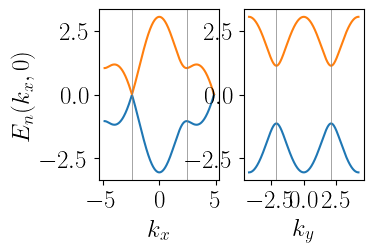

In [6]:
deltam = -0.001

t2 = 0.1 #0.1
phi = pi/2
m = 3sqrt(3) * t2 + deltam

nplot = 400

BZedgex = 4pi / 3
BZedgey = 8pi / (3sqrt(3))
kxplot = range(-BZedgex, BZedgex; length=nplot)
kyplot = range(-BZedgey, BZedgey; length=nplot)

bands = [eigvals(haldane([kx, ky], t2, phi, m)) for kx in kxplot, ky in kyplot]

fig, axs = subplots(ncols=2, figsize=(246/72, 160/72))
axs[1].plot(kyplot, bands[div(nplot, 2), :]);
axs[2].plot(kxplot, bands[:, div(nplot, 2)]);

axs[1].axvline(-4pi/(3sqrt(3)), color="gray", linewidth=0.5)
axs[1].axvline(4pi/(3sqrt(3)), color="gray", linewidth=0.5)

axs[2].axvline(-2pi / 3, color="gray", linewidth=0.5)
axs[2].axvline(2pi / 3, color="gray", linewidth=0.5)

axs[1].set_xlabel(L"$k_x$")
axs[2].set_xlabel(L"$k_y$")
axs[1].set_ylabel(L"$E_n(k_x, 0)$")

gap = minimum(b[2] for b in bands) - maximum(b[1] for b in bands)
println("Gap ≈ $gap")

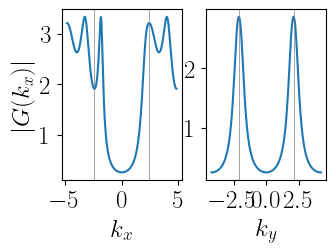

PyObject Text(34.906600249066, 0.5, '$|G(k_x)|$')

In [7]:
β = 10.0
μ = 1.0
gk = [ghaldane([kx, ky], t2, phi, m, β, μ) for kx in kxplot, ky in kyplot]

fig, axs = subplots(ncols=2, figsize=(246/72, 160/72))
axs[1].plot(kyplot, abs.(gk[div(nplot, 2), :]));
axs[2].plot(kxplot, abs.(gk[:, div(nplot, 2)]));

axs[1].axvline(-4pi/(3sqrt(3)), color="gray", linewidth=0.5)
axs[1].axvline(4pi/(3sqrt(3)), color="gray", linewidth=0.5)

axs[2].axvline(-2pi / 3, color="gray", linewidth=0.5)
axs[2].axvline(2pi / 3, color="gray", linewidth=0.5)

axs[1].set_xlabel(L"$k_x$")
axs[2].set_xlabel(L"$k_y$")
axs[1].set_ylabel(L"$|G(k_x)|$")

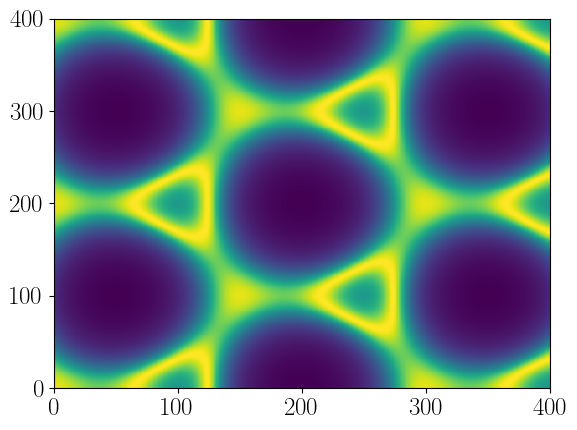

PyObject <matplotlib.collections.QuadMesh object at 0x17f4384c0>

In [8]:
pcolormesh(abs.(gk))

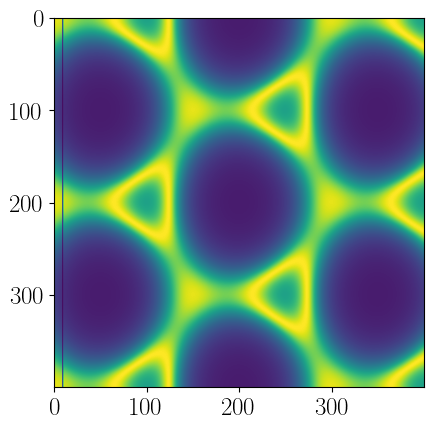

PyObject <matplotlib.image.AxesImage object at 0x17fad07c0>

In [9]:
Z = copy(gk)
Z[:, 10] .= 0.0
imshow(abs.(Z))

In [10]:
function tobins(i, nbit)
    @assert 1 ≤ i ≤ 2^nbit
    mask = 1 << (nbit-1)
    bin = ones(Int, nbit)
    for n in 1:nbit
        bin[n] = (mask & (i-1)) >> (nbit-n) + 1
        mask = mask >> 1
    end
    return bin
end

function frombins(bin)
    @assert all(1 .≤ bin .≤ 2)
    nbit = length(bin)
    i = 1
    tmp = 2^(nbit-1)
    for n in eachindex(bin)
        i += tmp * (bin[n] -1)
        tmp = tmp >> 1
    end
    return i
end

@assert frombins(tobins(4, 10)) == 4

In [11]:
function genfunc(t2, ϕ, m, β, μ)
    BZedgex = 4pi / 3
    BZedgey = 8pi / (3sqrt(3))
    function gkb(b)
        nbit = length(b) ÷ 2
        N = 2^nbit
        dkx = 2*BZedgex/N
        dky = 2*BZedgey/N
        ikx = frombins(b[1:2:end])
        iky = frombins(b[2:2:end])
        k = [dkx * (ikx-1) - BZedgex, dky * (iky-1) - BZedgey]
        return ghaldane(k, t2, ϕ, m, β, μ)
    end
end

function gengkdata(gkb, nbit)
    N = 2^nbit
    gkdata = zeros(ComplexF64, N, N)
    for ikx in 1:N, iky in 1:N
        bx = tobins(ikx, nbit)
        by = tobins(iky, nbit)
        b = collect(Iterators.flatten(zip(bx, by)))
        gkdata[ikx, iky] = gkb(b)
    end
    return gkdata
end
#gkdata = gengkdata(genfunc(t2, phi, m, β, μ), 10)
#pcolormesh(abs.(gkdata))

gengkdata (generic function with 1 method)

In [12]:
#betas = [1.0, 4.0, 16.0, 64.0, 128.0, 512.0]
betas = [16.0, 64.0, 512.0]
tols = [1e-3, 1e-4, 1e-5]
cutoffs_mps = [1e-6, 1e-8, 1e-10, 1e-12, 1e-14]
nbits = [10]

1-element Vector{Int64}:
 10

In [13]:
sites_nbit = Dict()
for nbit in nbits
    sitesx =  [Index(2, "Qubit,kx=$k") for k in 1:nbit]
    sitesy =  [Index(2, "Qubit,ky=$k") for k in 1:nbit]
    sites = collect(Iterators.flatten(zip(sitesx, sitesy)))
    sites_nbit[nbit] = sites
end

# TCI

In [14]:
maxiter = 10000
BLAS.set_num_threads(16)

qtts = Dict()
qtt_ranks = Dict()

for tol in tols
    for beta in betas
        for nbit in nbits
            @show tol, beta, nbit
            bx_ = tobins(1, nbit)
            by_ = tobins(2^(nbit-1), nbit)
            func = genfunc(t2, phi, m, beta, μ)
            firstpivot = TCI.optfirstpivot(func, fill(2, 2*nbit))
            qtt, ranks, errors = TCI.crossinterpolate(
                ComplexF64, func, fill(2, 2*nbit),
                firstpivot, tolerance=tol, maxiter=maxiter, verbosity=1
            )
            qtts[(beta,nbit,tol)] = qtt
            qtt_ranks[(beta,nbit,tol)] = ranks
        end
    end
end

(tol, beta, nbit) = (0.001, 16.0, 10)
rank= 10 , error= 1.1784997732357738
rank= 20 , error= 0.12681919202810674
rank= 30 , error= 0.009282648362628433
rank= 40 , error= 0.001937403496114065
(tol, beta, nbit) = (0.001, 64.0, 10)
rank= 10 , error= 1.8139280632061159
rank= 20 , error= 0.7765334989077531
rank= 30 , error= 0.27669392957605254
rank= 40 , error= 0.04018086388589238
rank= 50 , error= 0.012939538695201853
rank= 60 , error= 0.0013516565811188177
(tol, beta, nbit) = (0.001, 512.0, 10)
rank= 10 , error= 9.489048056250232
rank= 20 , error= 7.737883875395246
rank= 30 , error= 7.774663379993835
rank= 40 , error= 7.226441616778275
rank= 50 , error= 5.635359711372455
rank= 60 , error= 1.069509881910598
rank= 70 , error= 0.23732621995038425
rank= 80 , error= 0.008370320868891171
rank= 90 , error= 0.0009445348938688779
(tol, beta, nbit) = (0.0001, 16.0, 10)
rank= 10 , error= 1.1784997732357738
rank= 20 , error= 0.12681919202810674
rank= 30 , error= 0.009282648362628433
rank= 40 , error=

# MPS

In [15]:
mpss = Dict()
for beta in betas, nbit in nbits
    data_ref = gengkdata(genfunc(t2, phi, m, beta, μ), nbit)
    sites = sites_nbit[nbit]
    sitesx = sites[1:2:end]
    sitesy = sites[2:2:end]
    tensor = ITensor(data_ref, vcat(reverse(sitesx), reverse(sitesy)))
    for cutoff in cutoffs_mps
        key = (cutoff, beta, nbit)
        @show key
        mpss[key] = MPS(tensor, sites; cutoff=cutoff)
    end
end

key = (1.0e-6, 16.0, 10)
key = (1.0e-8, 16.0, 10)
key = (1.0e-10, 16.0, 10)
key = (1.0e-12, 16.0, 10)
key = (1.0e-14, 16.0, 10)
key = (1.0e-6, 64.0, 10)
key = (1.0e-8, 64.0, 10)
key = (1.0e-10, 64.0, 10)
key = (1.0e-12, 64.0, 10)
key = (1.0e-14, 64.0, 10)
key = (1.0e-6, 512.0, 10)
key = (1.0e-8, 512.0, 10)
key = (1.0e-10, 512.0, 10)
key = (1.0e-12, 512.0, 10)
key = (1.0e-14, 512.0, 10)


In [16]:
function reconst(mps, sites)
    nbit = length(sites) ÷ 2
    sitesx = sites[1:2:end]
    sitesy = sites[2:2:end]
    return reshape(Array(reduce(*, mps), [reverse(sitesx)..., reverse(sitesy)...]), 2^nbit, 2^nbit)
end

reconst (generic function with 1 method)

In [17]:
gk_reconst_qtt = Dict()
gk_ref_qtt = Dict()
for ((beta,nbit,tol),qtt) in qtts
    @show (beta,nbit,tol)
    mps = MSSTA.TCItoMPS(qtt, sites_nbit[nbit])
    data = reconst(mps, sites_nbit[nbit])
    data_ref = gengkdata(genfunc(t2, phi, m, beta, μ), nbit)
    gk_reconst_qtt[(beta,nbit,tol)] = data
    gk_ref_qtt[(beta,nbit,tol)] = data_ref
end

(beta, nbit, tol) = (512.0, 10, 0.001)
(beta, nbit, tol) = (16.0, 10, 1.0e-5)
(beta, nbit, tol) = (64.0, 10, 0.001)
(beta, nbit, tol) = (16.0, 10, 0.001)
(beta, nbit, tol) = (512.0, 10, 0.0001)
(beta, nbit, tol) = (512.0, 10, 1.0e-5)
(beta, nbit, tol) = (64.0, 10, 0.0001)
(beta, nbit, tol) = (16.0, 10, 0.0001)
(beta, nbit, tol) = (64.0, 10, 1.0e-5)


In [18]:
nbit = nbits[end]

plotdata_qtt = Dict()
plotdata_mps = Dict()

for beta in betas
    # QTT
    x_qtt = []
    y_qtt = []
    for tol in tols
        data = gk_reconst_qtt[(beta,nbit,tol)]
        data_ref = gk_ref_qtt[(beta,nbit,tol)]
        push!(x_qtt, TCI.rank(qtts[(beta,nbit,tol)]))
        push!(y_qtt, norm(data .- data_ref) / norm(data_ref))
    end
    plotdata_qtt[beta] = (x_qtt, y_qtt)

    # MPS
    x_mps = []
    y_mps = []
    for cutoff in cutoffs_mps
        key = (cutoff, beta, nbit)
        @show key
        data = reconst(mpss[key], sites_nbit[nbit])
        data_ref = gengkdata(genfunc(t2, phi, m, beta, μ), nbit)
        push!(x_mps, maximum(dim.(linkinds(mpss[key]))))
        push!(y_mps, norm(data .- data_ref) / norm(data_ref))
    end
    plotdata_mps[beta] = (x_mps, y_mps)

end

key = (1.0e-6, 16.0, 10)
key = (1.0e-8, 16.0, 10)
key = (1.0e-10, 16.0, 10)
key = (1.0e-12, 16.0, 10)
key = (1.0e-14, 16.0, 10)
key = (1.0e-6, 64.0, 10)
key = (1.0e-8, 64.0, 10)
key = (1.0e-10, 64.0, 10)
key = (1.0e-12, 64.0, 10)
key = (1.0e-14, 64.0, 10)
key = (1.0e-6, 512.0, 10)
key = (1.0e-8, 512.0, 10)
key = (1.0e-10, 512.0, 10)
key = (1.0e-12, 512.0, 10)
key = (1.0e-14, 512.0, 10)


In [19]:
#==
nbit = nbits[end]

pcolors = ["r", "b", "g", "k"]
markers = ["o", "x", "v", "+"]
ls = ["-", "-.", "--", ":"]

beta_plots = [4.0, 16.0, 64.0]

fig = figure(figsize=(6.4, 4.0))
for (i, beta) in enumerate(beta_plots)
    x_qtt, y_qtt = plotdata_qtt[beta]
    semilogy(x_qtt, y_qtt, marker="o", label=L"\mathrm{TCI}~(\beta=%$(Int(beta)))", ls=ls[i], c=pcolors[1])
end
    
for (i, beta) in enumerate(beta_plots)
    x_mps, y_mps = plotdata_mps[beta]
    semilogy(x_mps, y_mps, marker="x", label=L"\mathrm{SVD}~(\beta=%$(Int(beta)))", ls=ls[i], c=pcolors[2])
end

xlabel(L"D")
ylabel(L"|G(k) - G_\mathrm{exact}(k)|_2 / |G_\mathrm{exact}(k)|_2")
xlim([0, 160])
ylim([1e-7, 1e-1])
legend(frameon=false, fontsize=14)

tight_layout()
savefig("gk_scaling_nbit$(nbit).pdf", bbox_inches="tight", transparent=true, rasterized=true)

display(gcf())
close(gcf())
==#

maximum(abs, data .- data_ref) = 0.00021341637517860714
Dmax = 109


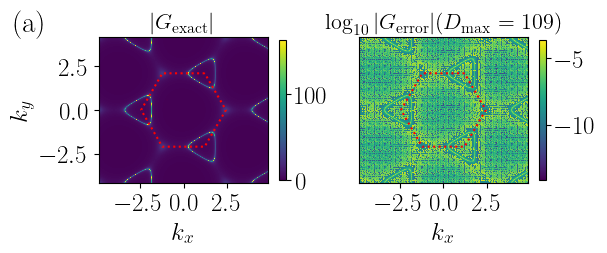

In [20]:
fig = figure(figsize=(6.4, 5.2))


let
    nbit = nbits[end]
    tol = tols[end]
    beta = betas[end]
    data = gk_reconst_qtt[(beta,nbit,tol)]
    data_ref = gk_ref_qtt[(beta,nbit,tol)]
    @show maximum(abs, data .- data_ref)
    mps = MSSTA.TCItoMPS(qtts[(beta,nbit,tol)])
    Dmax = maximum(dim.(linkinds(mps)))
    @show Dmax
    
    x = LinRange(-BZedgey, BZedgey, size(data_ref, 1)+1)[1:end-1]
    y = LinRange(-BZedgex, BZedgex, size(data_ref, 1)+1)[1:end-1]

    subplot(1, 2, 1)
    annotate("(a)", xycoords="axes fraction", xy=(-0.5,1.04), fontsize=21)
    title(L"|G_\mathrm{exact}|", fontsize=16)
    plt[:pcolormesh](x, y, abs.(data_ref), rasterized=true)
    #plt[:imshow](abs.(data_ref), origin="lower", extent = [-BZedgey, BZedgey, -BZedgex, BZedgex])
    ax = plt.gca().set_aspect("equal")
    xlabel(L"k_x")
    ylabel(L"k_y")
    #xticks([0, 1, 2])
    #yticks([0, 1, 2])
    clim([0, nothing])
    #colorbar(shrink=0.8, orientation="horizontal")
    colorbar(shrink=0.3)
    
    plot([y for (x, y) in BZcontour], [x for (x, y) in BZcontour], color="r", ls=":")

    subplot(1, 2, 2)
    title(L"\log_{10}|G_\mathrm{error}| (D_\mathrm{max}=%$(Dmax))", fontsize=16)
    plt[:pcolormesh](x, y, log10.(abs.(data .- data_ref)), rasterized=true)
    #plt[:imshow](log10.(abs.(data .- data_ref)), origin="lower", extent = [-BZedgey, BZedgey, -BZedgex, BZedgex])
    #annotate(L"D_\mathrm{max}=%$(Dmax)", xycoords="axes fraction", xy=(0.0,0.85), fontsize=18, weight="bold")
    ax = plt.gca().set_aspect("equal")
    xlabel(L"k_x")
    yticks([])
    #ylabel(L"k_y/\pi")
    #xticks([0, 1, 2])
    #yticks([0, 1, 2])
    #clim([-16, -4])
    #colorbar(shrink=0.8, orientation="horizontal")
    colorbar(shrink=0.3)
    plot([y for (x, y) in BZcontour], [x for (x, y) in BZcontour], color="r", ls=":")

    tight_layout()
end

savefig("dyson-a.pdf", bbox_inches="tight", transparent=true)

display(gcf())
close(gcf())

In [21]:
#==
nc = 1
fig = figure(figsize=(6.4, nc*3.2))
pcolors = ["r", "b", "g", "k"]
markers = ["o", "x", "v", "+"]
ls = ["-", "-.", "--", ":"]

annotate("(b)", xycoords="axes fraction", xy=(-0.2,0.92), fontsize=21)
maxL = 1
@show beta_plots
for (i, beta) in enumerate(beta_plots)
    key = (beta, nbits[end], tols[end])
    @show key
    mps = MSSTA.TCItoMPS(qtts[key])
    y = dim.(linkinds(mps))
    x = 1:length(y)
    maxL = max(maxL, length(y))
    semilogy(x, dim.(linkinds(mps)), marker=markers[i], c=pcolors[i], label=L"\beta=%$(Int(beta))", ls=ls[i])
    if i == 1
        maxy = MSSTA.maxlinkdims(siteinds(mps))
        semilogy(x, maxy, marker="", c="k", label="", ls="--")
    end
end

#ticker = matplotlib["ticker"]
#plt.axes().yaxis.set_minor_locator(ticker[:MultipleLocator](5))

xlabel(L"l")
xticks(1:2:maxL, fontsize=18)
ylabel(L"D_l")
ylim([1, 5000])
legend(frameon=false, fontsize=16)

tight_layout()

#savefig("dyson-b.pdf", bbox_inches="tight", transparent=true)

display(gcf())
close(gcf())
==#

(beta, y_qtt) = (16.0, Any[0.0001754109769734612, 1.7292375816412017e-5, 1.9179426634786826e-6])
(beta, y_qtt) = (64.0, Any[0.00013997308447918043, 1.2201358693259902e-5, 1.6956777859571675e-6])
(beta, y_qtt) = (512.0, Any[4.619466588895835e-5, 4.118560727864441e-6, 5.375914309688259e-7])


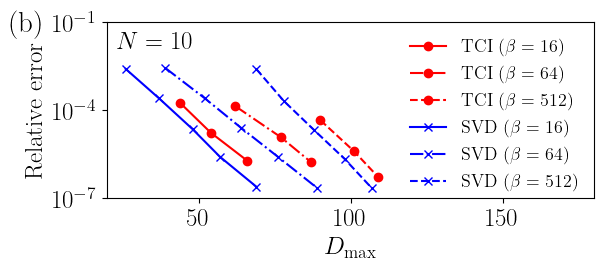

In [22]:
nc = 1
fig = figure(figsize=(6.4, nc*3.0))
pcolors = ["r", "b", "g", "k"]
markers = ["o", "x", "v", "+"]
ls = ["-", "-.", "--", ":"]

annotate("(b)", xycoords="axes fraction", xy=(-0.2,0.95), fontsize=21)
annotate(L"N=%$(nbit)", xycoords="axes fraction", xy=(0.02,0.85), fontsize=18)

for (i, beta) in enumerate([16.0, 64.0, 512.0])
    x_qtt, y_qtt = plotdata_qtt[beta]
    @show beta, y_qtt
    semilogy(x_qtt, y_qtt, marker="o", label=L"\mathrm{TCI}~(\beta=%$(Int(beta)))", ls=ls[i], c=pcolors[1])
end
    
for (i, beta) in enumerate([16.0, 64.0, 512.0])
    x_mps, y_mps = plotdata_mps[beta]
    semilogy(x_mps, y_mps, marker="x", label=L"\mathrm{SVD}~(\beta=%$(Int(beta)))", ls=ls[i], c=pcolors[2])
end

xlabel(L"D_\mathrm{max}")
#ylabel(L"|G(k) - G_\mathrm{exact}(k)|_2 / |G_\mathrm{exact}(k)|_2")
ylabel("Relative error")
xlim([20, 180])
ylim([1e-7, 1e-1])
legend(frameon=false, fontsize=13)

tight_layout()

savefig("dyson-b.pdf", bbox_inches="tight", transparent=true)

display(gcf())
close(gcf())

In [29]:
jldsave("haldane_gk_errors.jld2", mpsdata=plotdata_mps, tcidata=plotdata_qtt)